In [133]:
import wrds
import pandas_datareader.data as pdd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [128]:
FETCH_START_DATE = "1999-01-01"
START_DATE = "2000-01-01"
END_DATE = "2024-12-31"

In [169]:
try:
    db_num = wrds.Connection(wrds_username="audricms")
    print("Connection successful via .pgpass!")
except Exception as e:
    print(f"Connection failed: {e}")

Loading library list...
Done
Connection successful via .pgpass!


In [130]:
constituents_query = """
SELECT DISTINCT
    idx.gvkey,
    idx.tic as ticker,
    idx.companyname as company_name
FROM comp.wrds_idx_cst_current idx
WHERE idx.indexname LIKE '%%S&P 500%%'
  AND idx.indexname NOT LIKE '%%Equal Weight%%'
  AND idx.gvkey IN (
      SELECT gvkey 
      FROM comp.secd 
      WHERE datadate >= '2024-01-01'  -- Must have recent data
      AND secstat = 'A'               -- Must be marked 'Active'
  )
ORDER BY idx.tic
"""

print("Fetching Active S&P 500 constituents (Filtered by Security Status)...")
df_constituents = db_num.raw_sql(constituents_query)
print(f"Active Count: {len(df_constituents)}")

Fetching Active S&P 500 constituents (Filtered by Security Status)...
Active Count: 515


In [5]:
df_constituents = df_constituents.dropna().set_index("gvkey")
df_constituents.head()

,ticker,company_name
gvkey,,
126554,A,"Agilent Technologies, Inc."
001690,AAPL,Apple Inc.
016101,ABBV,AbbVie Inc.
037460,ABNB,"Airbnb, Inc."
001078,ABT,Abbott Laboratories


In [6]:
gvkeys = df_constituents.index.to_list()
gvkeys[:5]

['126554', '001690', '016101', '037460', '001078']

In [7]:
# We cast to tuple for SQL syntax
gvkeys_tuple = tuple(gvkeys)

In [ ]:
price_query = f"""
SELECT 
    gvkey, 
    iid, 
    datadate, 
    prccd AS close,       -- Raw Close Price
    prchd AS high,
    prcld AS low,
    div,                  -- Cash Dividends
    cshoc,                -- Shares Outstanding (for Market Cap)
    cshtrd AS volume     -- Trading Volume
FROM 
    comp.secd
WHERE 
    gvkey IN {gvkeys_tuple}
    AND datadate >= '{FETCH_START_DATE}' AND datadate <= '{END_DATE}'
    AND curcdd = 'USD'           -- Strict USD filter
ORDER BY 
    gvkey, iid, datadate
"""
print("Fetching current S&P 500 constituents price data from WRDS...")
df_prices = db_num.raw_sql(price_query, date_cols=["datadate"])

In [ ]:
df = df_prices.copy()

In [60]:
df_prices["mkt_cap"] = df_prices["close"] * df_prices["cshoc"]
primary_iids = df_prices.groupby(["gvkey", "iid"])["mkt_cap"].mean().reset_index()
primary_iids = (
    primary_iids.sort_values(["gvkey", "mkt_cap"], ascending=[True, False])
    .groupby("gvkey")
    .head(1)
)
df_prices = df_prices.merge(
    primary_iids[["gvkey", "iid"]], on=["gvkey", "iid"], how="inner"
)

In [61]:
df_prices["datadate"] = pd.to_datetime(df_prices["datadate"])
df_prices = df_prices.drop_duplicates(subset=["datadate", "gvkey"], keep="last")
df_prices = df_prices.sort_values(["gvkey", "datadate"])

In [38]:
df_prices["closel"] = df_prices["close"].ffill(limit=5)
df_prices["cshoc"] = df_prices["cshoc"].ffill(limit=5)
df_prices["mkt_cap"] = df_prices["mkt_cap"].ffill(limit=5)
df_prices["volume"] = df_prices["volume"].fillna(0.0)
df_prices["high"] = df_prices["high"].fillna(df_prices["close"])
df_prices["low"] = df_prices["low"].fillna(df_prices["close"])
df_prices.isna().sum()

gvkey                0
iid                  0
datadate             0
close                0
high                 0
low                  0
div            2829217
cshoc              147
volume               0
mkt_cap            272
closel               0
prev_close         508
raw_ratio            0
split_ratio          0
dtype: int64

In [62]:
# Detect Splits
df_prices["prev_close"] = df_prices.groupby("gvkey")["close"].shift(1)
df_prices["raw_ratio"] = (df_prices["prev_close"] / df_prices["close"]).fillna(1.0)

# Define Split Candidates
# --- Forward Splits (Price Drops) ---
c_2_1 = df_prices["raw_ratio"].between(1.90, 2.10).fillna(False)  # Standard 2:1
c_3_1 = df_prices["raw_ratio"].between(2.90, 3.10).fillna(False)  # 3:1
c_4_1 = df_prices["raw_ratio"].between(3.90, 4.10).fillna(False)  # 4:1
c_3_2 = df_prices["raw_ratio"].between(1.45, 1.55).fillna(False)  # 3:2
c_5_1 = df_prices["raw_ratio"].between(4.90, 5.10).fillna(False)  # 5:1
c_10_1 = df_prices["raw_ratio"].between(9.50, 10.5).fillna(False)  # 10:1
c_20_1 = df_prices["raw_ratio"].between(19.0, 21.0).fillna(False)  # 20:1

# --- Reverse Splits (Price Jumps) ---
c_1_2 = df_prices["raw_ratio"].between(0.48, 0.52).fillna(False)  # 1:2
c_1_3 = df_prices["raw_ratio"].between(0.31, 0.35).fillna(False)  # 1:3
c_1_4 = df_prices["raw_ratio"].between(0.23, 0.27).fillna(False)  # 1:4
c_1_5 = df_prices["raw_ratio"].between(0.18, 0.22).fillna(False)  # 1:5
c_1_8 = df_prices["raw_ratio"].between(0.11, 0.14).fillna(False)  # 1:8
c_1_10 = df_prices["raw_ratio"].between(0.09, 0.11).fillna(False)  # 1:10
c_1_20 = df_prices["raw_ratio"].between(0.04, 0.06).fillna(False)  # 1:20

conditions = [
    c_2_1,
    c_3_1,
    c_4_1,
    c_3_2,
    c_5_1,
    c_10_1,
    c_20_1,
    c_1_2,
    c_1_3,
    c_1_4,
    c_1_5,
    c_1_8,
    c_1_10,
    c_1_20,
]

choices = [
    2.0,
    3.0,
    4.0,
    1.5,
    5.0,
    10.0,
    20.0,
    0.5,
    0.3333,
    0.25,
    0.2,
    0.125,
    0.1,
    0.05,
]

df_prices["split_ratio"] = np.select(conditions, choices, default=1.0)
df_prices["cum_adj_factor"] = df_prices.groupby("gvkey")["split_ratio"].cumprod()

In [65]:
df_prices.prev_close

0             <NA>
1           42.875
2          42.8125
3            42.75
4           42.375
            ...   
2862265     132.13
2862266     133.04
2862267     132.99
2862268     131.97
2862269     130.97
Name: prev_close, Length: 2862270, dtype: Float64

In [66]:
# Construct Total Daily Return
df_prices["div"] = df_prices["div"].fillna(0.0)
df_prices["temp_adj_close"] = (
    df_prices["close"] * df_prices["split_ratio"]
) + df_prices["div"]
df_prices["total_ret"] = (df_prices["temp_adj_close"] / df_prices["prev_close"]) - 1.0

mask_outliers = (df_prices["total_ret"].abs() > 0.5) & (df_prices["split_ratio"] == 1.0)
if mask_outliers.any():
    print(f"Neutralizing {mask_outliers.sum()} flash-crash artifacts...")
    df_prices.loc[mask_outliers, "total_ret"] = 0.0

df_prices["log_ret"] = np.log1p(df_prices["total_ret"].fillna(0))
df_prices["cum_log_ret"] = df_prices.groupby("gvkey")["log_ret"].cumsum()
first_prices = df_prices.groupby("gvkey")["close"].transform("first")
df_prices["adj_close"] = np.exp(df_prices["cum_log_ret"]) * first_prices


# Construct Adjusted High/Low
# These are adjusted ONLY for splits, NOT dividends (to preserve intraday range)
df_prices = df_prices.sort_values(["gvkey", "datadate"], ascending=[True, False])
df_prices["cum_split_factor"] = df_prices.groupby("gvkey")["split_ratio"].cumprod()

df_prices["adj_high"] = df_prices["high"] * df_prices["cum_split_factor"]
df_prices["adj_low"] = df_prices["low"] * df_prices["cum_split_factor"]

df_prices = df_prices.sort_values(["gvkey", "datadate"])
df_prices.loc[mask_outliers, ["adj_high", "adj_low"]] = np.nan
df_prices[["adj_high", "adj_low"]] = df_prices.groupby("gvkey")[
    ["adj_high", "adj_low"]
].transform(lambda x: x.interpolate(method="linear"))

<Axes: xlabel='datadate'>

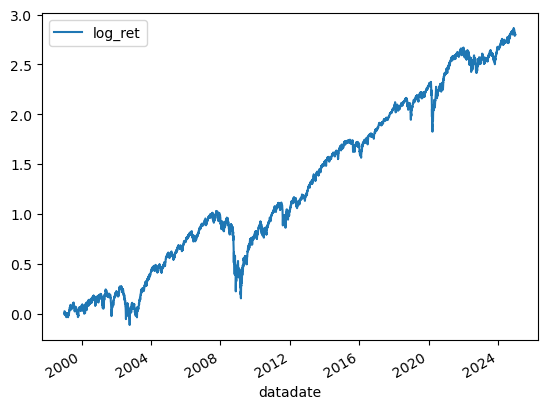

In [72]:
df_prices[["datadate", "log_ret"]].groupby("datadate").mean().cumsum().plot()

In [92]:
df_prices["volatility_parkinson"] = (
    np.sqrt(
        (1 / (4 * np.log(2)))
        * (np.log(df_prices["adj_high"] / df_prices["adj_low"]) ** 2)
    )
    .clip(lower=1e-6)
    .fillna(0)
)

df_prices["mom_1w"] = df_prices.groupby("gvkey")["log_ret"].transform(
    lambda x: x.rolling(5).sum()
)
df_prices["mom_1m"] = df_prices.groupby("gvkey")["log_ret"].transform(
    lambda x: x.rolling(21).sum()
)
df_prices[["mom_1w", "mom_1m"]] = df_prices[["mom_1w", "mom_1m"]].fillna(0.0)

# Position relative to 200-day Trend (Long-term Trend)
df_prices["ma_200"] = df_prices.groupby("gvkey")["adj_close"].transform(
    lambda x: x.rolling(200).mean()
)
df_prices["trend_dev_200d"] = (df_prices["adj_close"] / df_prices["ma_200"]) - 1.0

# Rolling Max Price (Last 252 days)
df_prices["rolling_max"] = df_prices.groupby("gvkey")["adj_close"].transform(
    lambda x: x.rolling(252).max()
)

# Drawdown Feature (Percentage drop from peak)
df_prices["drawdown"] = (df_prices["adj_close"] / df_prices["rolling_max"]) - 1.0

#  Relative Volume
df_prices["log_volume"] = np.log1p(df_prices["volume"])
df_prices["vol_ma20"] = df_prices.groupby("gvkey")["log_volume"].transform(
    lambda x: x.rolling(window=20, min_periods=10).mean()
)
df_prices["relative_volume"] = (df_prices["log_volume"] - df_prices["vol_ma20"]).fillna(
    0
)

In [93]:
df_prices["target"] = df_prices.groupby("gvkey")["log_ret"].shift(-1)

In [94]:
df_prices

,gvkey,iid,datadate,close,high,low,div,cshoc,volume,mkt_cap,...,mom_1w,mom_1m,ma_200,trend_dev_200d,rolling_max,drawdown,target,log_volume,vol_ma20,relative_volume
0,001075,01,1999-01-04,42.875,43.375,42.4375,0.0,84733000.0,348400.0,3632927375.0,...,0.000000,0.000000,NaN,<NA>,NaN,<NA>,-0.001459,12.761109,NaN,0.0
1,001075,01,1999-01-05,42.8125,43.3125,42.625,0.0,84733000.0,287000.0,3627631562.5,...,0.000000,0.000000,NaN,<NA>,NaN,<NA>,-0.001461,12.567241,NaN,0.0
2,001075,01,1999-01-06,42.75,43.0,41.75,0.0,84733000.0,312300.0,3622335750.0,...,0.000000,0.000000,NaN,<NA>,NaN,<NA>,-0.008811,12.651723,NaN,0.0
3,001075,01,1999-01-07,42.375,42.75,42.0,0.0,84733000.0,86500.0,3590560875.0,...,0.000000,0.000000,NaN,<NA>,NaN,<NA>,-0.022372,11.367911,NaN,0.0
4,001075,01,1999-01-08,41.4375,42.25,40.875,0.0,84733000.0,434900.0,3511123687.5,...,-0.034103,0.000000,NaN,<NA>,NaN,<NA>,-0.009091,12.982874,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862265,316056,01,2024-12-24,133.04,133.13,131.395,0.0,86929000.0,248818.0,11565034160.0,...,-0.026700,-0.057295,148.040966,0.011363,171.987021,-0.129451,-0.000376,12.424481,13.512578,-1.088097
2862266,316056,01,2024-12-26,132.99,134.0,132.025,0.0,86929000.0,386689.0,11560687710.0,...,0.003842,-0.066754,148.051402,0.010911,171.987021,-0.129778,-0.007699,12.865379,13.469435,-0.604056
2862267,316056,01,2024-12-27,131.97,133.33,131.43,0.0,86929000.0,428983.0,11472020130.0,...,0.010206,-0.058343,148.057872,0.003114,171.987021,-0.136453,-0.007606,12.969175,13.434564,-0.465389
2862268,316056,01,2024-12-30,130.97,131.5655,129.6086,0.0,86929000.0,298177.0,11385091130.0,...,-0.009196,-0.073188,148.071025,-0.004576,171.987021,-0.142996,-0.002217,12.605446,13.424638,-0.819192


In [95]:
dates = pd.to_datetime(df_prices["datadate"].unique())
companies = df_prices["gvkey"].unique()
index = pd.MultiIndex.from_product([dates, companies], names=["date", "gvkey"])
index

MultiIndex([('1999-01-04', '001075'),
            ('1999-01-04', '001078'),
            ('1999-01-04', '001161'),
            ('1999-01-04', '001209'),
            ('1999-01-04', '001300'),
            ('1999-01-04', '001327'),
            ('1999-01-04', '001440'),
            ('1999-01-04', '001447'),
            ('1999-01-04', '001449'),
            ('1999-01-04', '001487'),
            ...
            ('2024-12-31', '185532'),
            ('2024-12-31', '186310'),
            ('2024-12-31', '186989'),
            ('2024-12-31', '187450'),
            ('2024-12-31', '187697'),
            ('2024-12-31', '189491'),
            ('2024-12-31', '260774'),
            ('2024-12-31', '283184'),
            ('2024-12-31', '294524'),
            ('2024-12-31', '316056')],
           names=['date', 'gvkey'], length=3322828)

In [96]:
df_prices_expanded = (
    df_prices.set_index(["datadate", "gvkey"]).reindex(index).reset_index()
)


In [97]:
# Create the 'is_active' Mask
# A row is active ONLY if it has valid critical features
required_features = ["log_ret", "mom_1m", "trend_dev_200d", "volatility_parkinson"]
df_prices_expanded["is_active"] = (
    df_prices_expanded[required_features].notna().all(axis=1).astype(float)
)

# Also ensure the Target exists (we cannot train on the very last day)
df_prices_expanded["is_active"] = df_prices_expanded["is_active"] * df_prices_expanded[
    "target"
].notna().astype(float)

cols_to_fill = required_features + ["target"]
df_prices_expanded[cols_to_fill] = df_prices_expanded[cols_to_fill].fillna(0.0)

In [158]:
cols_price_features = [
    "date",
    "gvkey",
    "log_ret",
    "volatility_parkinson",
    "mom_1w",
    "mom_1m",
    "trend_dev_200d",
    "drawdown",
    "log_volume",
    "relative_volume",
    "target",
    "is_active",
]
df_price_features = df_prices_expanded[df_prices_expanded["date"] >= START_DATE][
    cols_price_features
]
df_price_features.describe().round(3)

,date,log_ret,volatility_parkinson,mom_1w,mom_1m,trend_dev_200d,drawdown,log_volume,relative_volume,target,is_active
count,3194812,3194812.0,3194812.0,2775594.000,3194812.000,3194812.0,2734721.0,2775594.0,2775594.0,3194812.0,3194812.000
mean,2012-07-03 00:57:42.044839424,0.0,0.014,0.002,0.008,0.044,-0.133,14.268,0.002,0.0,0.859
min,2000-01-03 00:00:00,-0.637,0.0,-1.250,-2.271,-0.948,-0.982,0.0,-14.427,-0.637,0.000
25%,2006-04-05 00:00:00,-0.007,0.007,-0.019,-0.026,-0.017,-0.189,13.437,-0.255,-0.007,1.000
50%,2012-07-02 00:00:00,0.0,0.011,0.003,0.001,0.03,-0.085,14.311,-0.027,0.0,1.000
75%,2018-10-01 00:00:00,0.008,0.017,0.025,0.052,0.121,-0.028,15.201,0.225,0.008,1.000
max,2024-12-31 00:00:00,0.405,4.569,1.242,1.955,5.731,0.0,22.051,13.635,0.405,1.000
std,NaN,0.022,0.013,0.051,0.094,0.159,0.143,1.558,0.425,0.022,0.349


In [159]:
# Winsorization

# Parkinson: Cap at 0.15 (Roughly a 30% intraday range)
# Anything higher is almost certainly a data error or a delisting event.
df_price_features["volatility_parkinson"] = df_price_features[
    "volatility_parkinson"
].clip(upper=0.15)

# Trend Deviation: Cap at 1.0 (100% above 200d MA)
df_price_features["trend_dev_200d"] = df_price_features["trend_dev_200d"].clip(
    lower=-0.8, upper=1.0
)

# Drawdown: It can't be positive.
df_price_features["drawdown"] = df_price_features["drawdown"].clip(upper=0.0)

# Relative Volume: Cap at 4.0 (Significant but not astronomical)
df_price_features["relative_volume"] = df_price_features["relative_volume"].clip(
    lower=-4.0, upper=4.0
)

In [160]:
df_price_features.describe().round(3)

,date,log_ret,volatility_parkinson,mom_1w,mom_1m,trend_dev_200d,drawdown,log_volume,relative_volume,target,is_active
count,3194812,3194812.0,3194812.0,2775594.000,3194812.000,3194812.0,2734721.0,2775594.0,2775594.0,3194812.0,3194812.000
mean,2012-07-03 00:57:42.044839424,0.0,0.014,0.002,0.008,0.044,-0.133,14.268,0.002,0.0,0.859
min,2000-01-03 00:00:00,-0.637,0.0,-1.250,-2.271,-0.8,-0.982,0.0,-4.0,-0.637,0.000
25%,2006-04-05 00:00:00,-0.007,0.007,-0.019,-0.026,-0.017,-0.189,13.437,-0.255,-0.007,1.000
50%,2012-07-02 00:00:00,0.0,0.011,0.003,0.001,0.03,-0.085,14.311,-0.027,0.0,1.000
75%,2018-10-01 00:00:00,0.008,0.017,0.025,0.052,0.121,-0.028,15.201,0.225,0.008,1.000
max,2024-12-31 00:00:00,0.405,0.15,1.242,1.955,1.0,0.0,22.051,4.0,0.405,1.000
std,NaN,0.022,0.013,0.051,0.094,0.156,0.143,1.558,0.421,0.022,0.349


In [161]:
df_price_features = (
    df_price_features.set_index(["date", "gvkey"]).reindex(index).loc[START_DATE:]
)
df_price_features.head()

log_ret  volatility_parkinson    mom_1w    mom_1m  \
date       gvkey                                                        
2000-01-03 001075 -0.026945              0.018867 -0.045182 -0.114978   
           001078 -0.036814              0.021223 -0.060625 -0.062304   
           001161  0.068849              0.035958  0.068849  0.058108   
           001209   -0.0226               0.01695  0.066212  0.011079   
           001300 -0.017487              0.020891  0.041649 -0.069213   

                   trend_dev_200d  drawdown  log_volume  relative_volume  \
date       gvkey                                                           
2000-01-03 001075       -0.196941 -0.286444    12.41431        -0.103902   
           001078       -0.175373 -0.333217   15.378716          0.00778   
           001161        0.551673 -0.027451   15.182011         0.655084   
           001209       -0.074348 -0.321225   13.219855        -0.052313   
           001300        -0.05352 -0.162533   14.557829         -0.33225   

                     target  is_active  
date       gvkey                        
2000-01-03 001075  0.012526        1.0  
           001078 -0.028988        1.0  
           001161 -0.058108        1.0  
           001209  -0.03095        1.0  
           001300 -0.017798        1.0

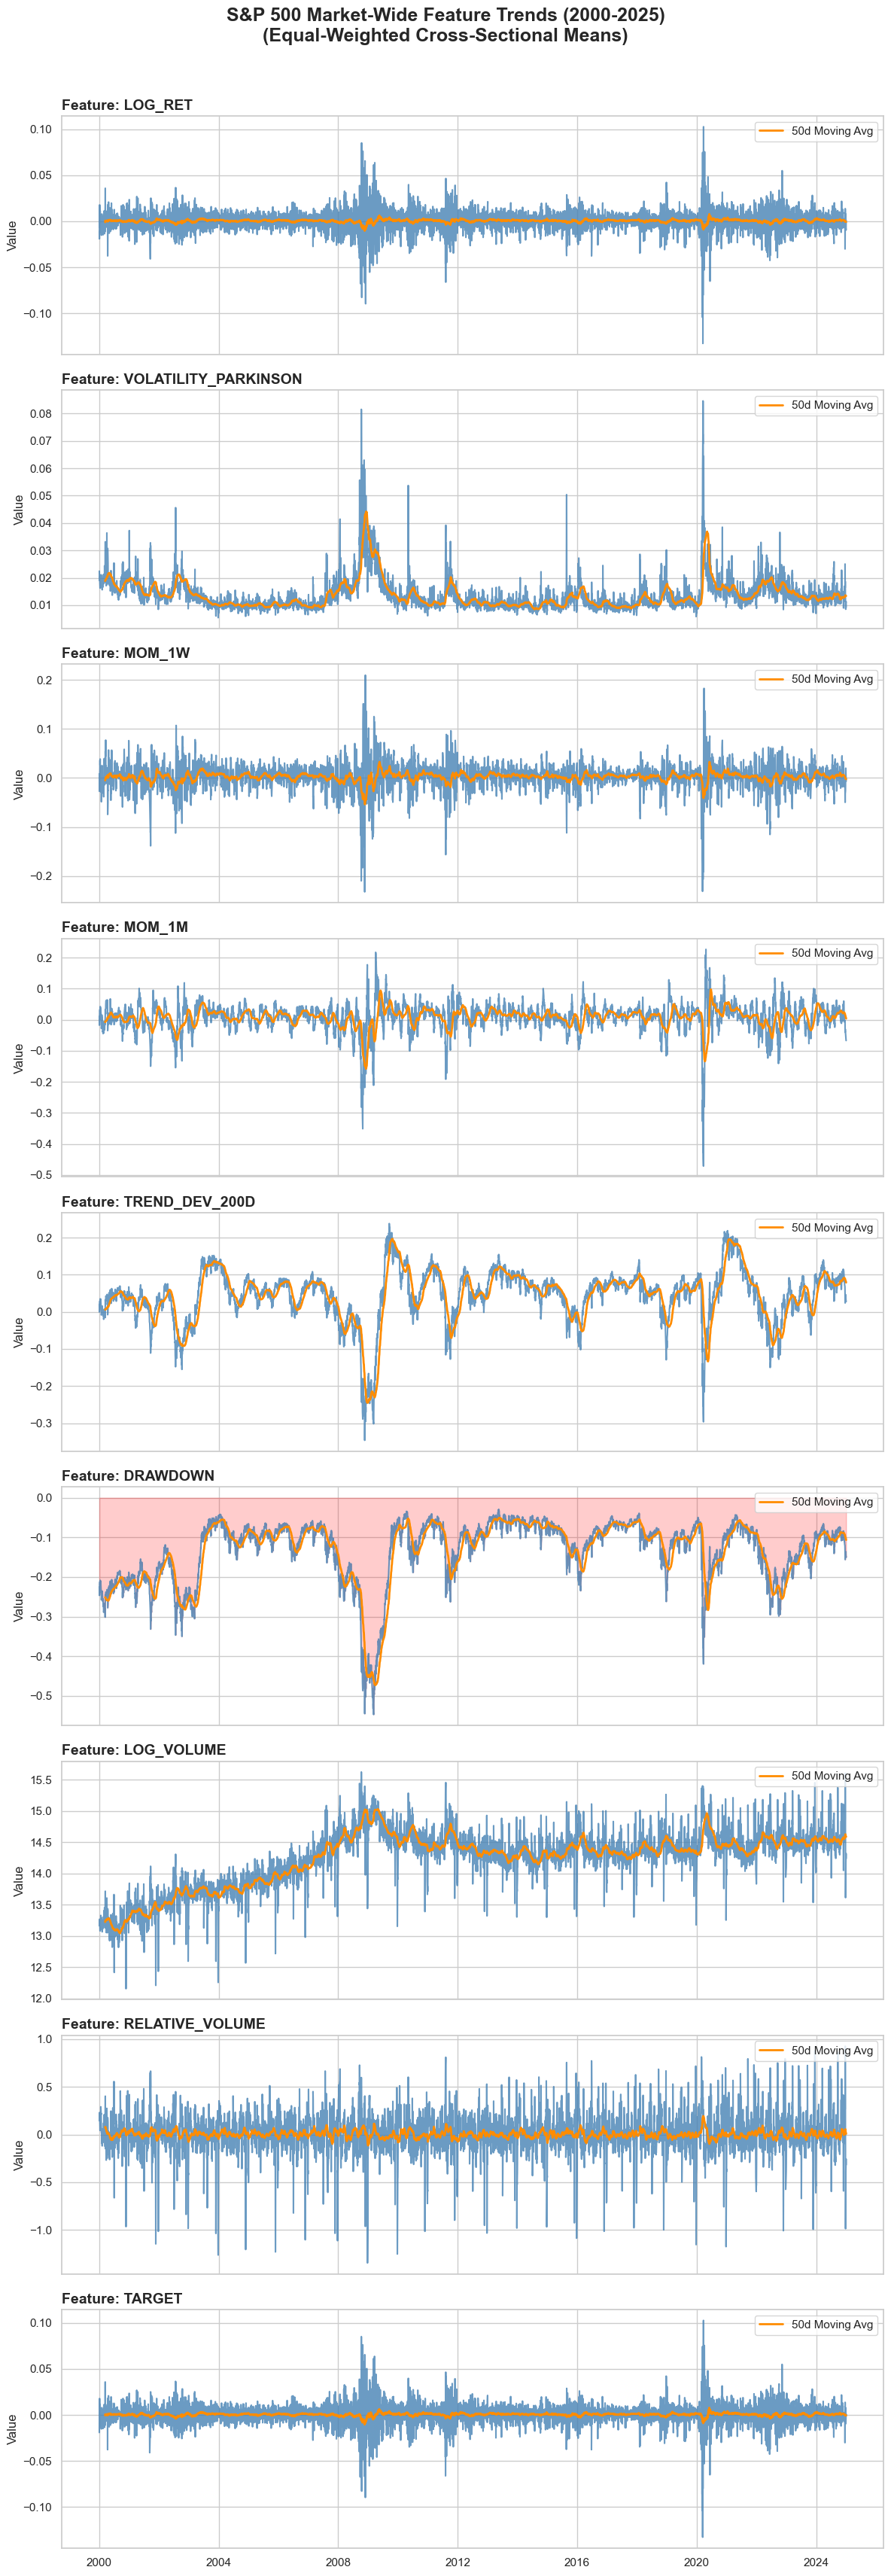

In [162]:
sns.set_theme(style="whitegrid")
features_to_plot = [
    col for col in df_price_features.columns if col not in ["is_active"]
]

fig, axes = plt.subplots(
    nrows=len(features_to_plot),
    ncols=1,
    figsize=(12, 4 * len(features_to_plot)),
    sharex=True,
)
fig.suptitle(
    "S&P 500 Market-Wide Feature Trends (2000-2025)\n(Equal-Weighted Cross-Sectional Means)",
    fontsize=18,
    fontweight="bold",
)

for i, col in enumerate(features_to_plot):
    data = df_price_features[col].groupby(level="date").mean()

    axes[i].plot(data.index, data.values, color="steelblue", linewidth=1.5, alpha=0.8)

    axes[i].plot(
        data.index,
        data.rolling(50).mean(),
        color="darkorange",
        linewidth=2,
        label="50d Moving Avg",
    )

    axes[i].set_title(
        f"Feature: {col.upper()}", fontsize=14, loc="left", fontweight="semibold"
    )
    axes[i].set_ylabel("Value")
    axes[i].legend(loc="upper right")

    if col == "drawdown":
        axes[i].fill_between(data.index, data.values, 0, color="red", alpha=0.2)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

In [120]:
gvkeys_tuple = tuple(df_price_features.index.get_level_values(1).unique())

In [170]:
ratios_query = f"""
SELECT 
    gvkey,
    ticker, public_date,
    ptb,                -- Price to Book (Value)
    pe_exi as pe,       -- P/E Excl. Extraordinary Items (Valuation)
    roe,                -- Return on Equity (Quality)
    de_ratio as dte,    -- Debt to Equity (Leverage)
    divyield            -- Dividend Yield (Income)
FROM wrdsapps.firm_ratio
WHERE gvkey IN {gvkeys_tuple}
AND public_date >= '{FETCH_START_DATE}' -- Fetch earlier to fill 2000 start
ORDER BY ticker, public_date
"""
print("Fetching current S&P 500 constituents financial ratios data from WRDS...")
df_ratios = db_num.raw_sql(ratios_query)

Fetching current S&P 500 constituents financial ratios data from WRDS...


In [171]:
df_ratios["public_date"] = pd.to_datetime(df_ratios["public_date"])
df_ratios = df_ratios.sort_values("public_date")

cols_ratios = ["ptb", "pe", "roe", "dte", "divyield"]
for col in cols_ratios:
    if col in df_ratios.columns:
        df_ratios[col] = df_ratios[col].replace([np.inf, -np.inf], np.nan)
        df_ratios[col] = df_ratios[col].clip(-300, 300)

        if col == "divyield":
            # For dividends, missing usually means 0 (Didn't pay)
            df_ratios[col] = df_ratios[col].fillna(0.0)
        else:
            daily_median = df_ratios.groupby("public_date")[col].transform("median")
            df_ratios[col] = df_ratios[col].fillna(daily_median)
            df_ratios[col] = df_ratios[col].ffill()

In [172]:
df_ratios["log_dte"] = np.log1p(df_ratios["dte"].clip(lower=0, upper=100))
df_ratios["log_dte"] = df_ratios["dte"].clip(upper=10.0)
df_ratios = df_ratios.drop(columns="dte")
df_ratios

,gvkey,ticker,public_date,ptb,pe,roe,divyield,log_dte
24039,003226,CMCSK,1999-01-31,5.091344,19.043242,0.148349,0.0,5.337765
100018,009667,SHW,1999-01-31,2.570983,5.510753,0.168492,0.017561,1.538016
64918,006304,KLAC,1999-01-31,4.199693,53.971963,0.082155,0.0,0.288204
22463,002991,CHV,1999-01-31,2.293328,20.299728,0.116526,0.032752,1.051885
52185,005256,GWW,1999-01-31,2.969725,17.121849,0.176951,0.014724,0.539804
...,...,...,...,...,...,...,...,...
67088,165123,LDOS,2024-12-31,4.166094,16.389078,0.280977,0.011106,1.940381
67400,006669,LEN,2024-12-31,1.188001,9.043103,0.158755,0.014666,0.451463
67712,014960,LH,2024-12-31,2.347568,44.27027,0.054288,0.012559,1.140541
86908,036190,OTIS,2024-12-31,3.541925,23.037313,0.16015,0.016845,-2.976879


In [173]:
df_left = df_price_features.reset_index()
df_pfr = pd.merge_asof(
    df_left,
    df_ratios,
    left_on="date",
    right_on="public_date",
    by="gvkey",
    direction="backward",
    tolerance=pd.Timedelta(days=365),
)
df_pfr = df_pfr.drop(columns=["public_date", "ticker"])
df_pfr = df_pfr.set_index(["date", "gvkey"]).sort_index()

cols_ratios = ["ptb", "pe", "roe", "log_dte", "divyield"]
for col in cols_ratios:
    daily_medians = df_pfr.groupby("date")[col].transform("median")
    df_pfr[col] = df_pfr[col].fillna(daily_medians)
    df_pfr[col] = df_pfr[col].fillna(0.0)

In [174]:
df_pfr.head()

log_ret  volatility_parkinson    mom_1w    mom_1m  \
date       gvkey                                                        
2000-01-03 001075 -0.026945              0.018867 -0.045182 -0.114978   
           001078 -0.036814              0.021223 -0.060625 -0.062304   
           001161  0.068849              0.035958  0.068849  0.058108   
           001209   -0.0226               0.01695  0.066212  0.011079   
           001300 -0.017487              0.020891  0.041649 -0.069213   

                   trend_dev_200d  drawdown  log_volume  relative_volume  \
date       gvkey                                                           
2000-01-03 001075       -0.196941 -0.286444    12.41431        -0.103902   
           001078       -0.175373 -0.333217   15.378716          0.00778   
           001161        0.551673 -0.027451   15.182011         0.655084   
           001209       -0.074348 -0.321225   13.219855        -0.052313   
           001300        -0.05352 -0.162533   14.557829         -0.33225   

                     target  is_active       ptb         pe       roe  \
date       gvkey                                                        
2000-01-03 001075  0.012526        1.0  0.767825   9.987745  0.074962   
           001078 -0.028988        1.0  8.369792  23.427419  0.406466   
           001161 -0.058108        1.0  2.163137 -16.076389 -0.066714   
           001209  -0.03095        1.0  2.084125  16.058612  0.127566   
           001300 -0.017798        1.0  7.313876  22.891865   0.31842   

                   divyield   log_dte  
date       gvkey                       
2000-01-03 001075  0.045808  2.087454  
           001078  0.018726  1.139959  
           001161       0.0   1.18866  
           001209  0.021453  1.737777  
           001300  0.011788  1.850449

In [175]:
start_macro = pd.to_datetime("1998-01-01")
end_macro = pd.to_datetime("2025-06-01")

# CPIAUCSL: Inflation, UNRATE: Unemployment, PPIACO: Producer Prices
print("Fetching macroeconomic data from FRED...")
df_macro = pdd.DataReader(
    ["CPIAUCSL", "UNRATE", "PPIACO"], "fred", start_macro, end_macro
)

Fetching macroeconomic data from FRED...


In [176]:
df_macro["cpi_yoy"] = df_macro["CPIAUCSL"].pct_change(12).clip(lower=-0.2, upper=0.3)
df_macro["ppi_yoy"] = df_macro["PPIACO"].pct_change(12).clip(lower=-0.2, upper=0.3)
df_macro["unemp_rate"] = df_macro["UNRATE"].div(100).clip(0.0, 0.3)
df_macro["unemp_delta"] = df_macro["UNRATE"].diff()

# LAG CORRECTION: Shift dates +1 Month
df_macro.index = df_macro.index + pd.DateOffset(months=1, days=15)
df_macro = df_macro.reset_index().rename(columns={"DATE": "macro_date"})

In [177]:
df_macro.head()

,macro_date,CPIAUCSL,UNRATE,PPIACO,cpi_yoy,ppi_yoy,unemp_rate,unemp_delta
0,1998-02-16,162.0,4.6,125.4,NaN,NaN,0.046,NaN
1,1998-03-16,162.0,4.6,125.0,NaN,NaN,0.046,0.0
2,1998-04-16,162.0,4.7,124.7,NaN,NaN,0.047,0.1
3,1998-05-16,162.2,4.3,124.9,NaN,NaN,0.043,-0.4
4,1998-06-16,162.6,4.4,125.1,NaN,NaN,0.044,0.1


In [178]:
df_left = df_pfr.reset_index()
df_macro = df_macro.sort_values("macro_date")
df_num = pd.merge_asof(
    df_left.sort_values("date"),
    df_macro[["macro_date", "cpi_yoy", "ppi_yoy", "unemp_rate", "unemp_delta"]],
    left_on="date",
    right_on="macro_date",
    direction="backward",
).drop(columns=["macro_date"])

In [179]:
df_num = df_num.set_index(["date", "gvkey"]).sort_index().loc[START_DATE:]
df_num.head()

log_ret  volatility_parkinson    mom_1w    mom_1m  \
date       gvkey                                                        
2000-01-03 001075 -0.026945              0.018867 -0.045182 -0.114978   
           001078 -0.036814              0.021223 -0.060625 -0.062304   
           001161  0.068849              0.035958  0.068849  0.058108   
           001209   -0.0226               0.01695  0.066212  0.011079   
           001300 -0.017487              0.020891  0.041649 -0.069213   

                   trend_dev_200d  drawdown  log_volume  relative_volume  \
date       gvkey                                                           
2000-01-03 001075       -0.196941 -0.286444    12.41431        -0.103902   
           001078       -0.175373 -0.333217   15.378716          0.00778   
           001161        0.551673 -0.027451   15.182011         0.655084   
           001209       -0.074348 -0.321225   13.219855        -0.052313   
           001300        -0.05352 -0.162533   14.557829         -0.33225   

                     target  is_active       ptb         pe       roe  \
date       gvkey                                                        
2000-01-03 001075  0.012526        1.0  0.767825   9.987745  0.074962   
           001078 -0.028988        1.0  8.369792  23.427419  0.406466   
           001161 -0.058108        1.0  2.163137 -16.076389 -0.066714   
           001209  -0.03095        1.0  2.084125  16.058612  0.127566   
           001300 -0.017798        1.0  7.313876  22.891865   0.31842   

                   divyield   log_dte   cpi_yoy   ppi_yoy  unemp_rate  \
date       gvkey                                                        
2000-01-03 001075  0.045808  2.087454  0.026204  0.038026       0.041   
           001078  0.018726  1.139959  0.026204  0.038026       0.041   
           001161       0.0   1.18866  0.026204  0.038026       0.041   
           001209  0.021453  1.737777  0.026204  0.038026       0.041   
           001300  0.011788  1.850449  0.026204  0.038026       0.041   

                   unemp_delta  
date       gvkey                
2000-01-03 001075          0.0  
           001078          0.0  
           001161          0.0  
           001209          0.0  
           001300          0.0

In [180]:
df_num.describe()

,log_ret,volatility_parkinson,mom_1w,mom_1m,trend_dev_200d,drawdown,log_volume,relative_volume,target,is_active,ptb,pe,roe,divyield,log_dte,cpi_yoy,ppi_yoy,unemp_rate,unemp_delta
count,3194812.0,3194812.0,2.775594e+06,3.194812e+06,3194812.0,2734721.0,2775594.0,2775594.0,3194812.0,3.194812e+06,3194812.0,3194812.0,3194812.0,3194812.0,3194812.0,3.194812e+06,3.194812e+06,3.194812e+06,3.194812e+06
mean,0.00038,0.013678,2.204789e-03,8.168939e-03,0.043876,-0.132699,14.267656,0.002428,0.000382,8.585194e-01,4.607698,19.37185,0.177693,0.014875,1.538269,2.577495e-02,3.118444e-02,5.696375e-02,-2.035300e-03
std,0.021693,0.01268,5.050859e-02,9.379461e-02,0.155503,0.14345,1.557685,0.420551,0.021687,3.485167e-01,6.867188,45.815885,0.798179,0.028237,11.211033,1.761564e-02,6.887620e-02,1.956980e-02,6.438840e-01
min,-0.636958,0.0,-1.249538e+00,-2.271400e+00,-0.8,-0.98241,0.0,-4.0,-0.636958,0.000000e+00,0.049212,-300.0,-51.780302,0.0,-300.0,-1.958761e-02,-1.605839e-01,3.400000e-02,-2.200000e+00
25%,-0.007183,0.006879,-1.937660e-02,-2.611131e-02,-0.016753,-0.188627,13.437391,-0.255062,-0.007179,1.000000e+00,1.966617,11.891892,0.101958,0.002339,1.017538,1.603666e-02,-1.135323e-02,4.200000e-02,-1.000000e-01
50%,0.0,0.011067,3.448592e-03,9.498580e-04,0.029642,-0.085458,14.310986,-0.026728,0.0,1.000000e+00,2.932256,17.108458,0.148973,0.011604,1.487666,2.317891e-02,3.747073e-02,5.100000e-02,0.000000e+00
75%,0.008371,0.017321,2.540656e-02,5.178036e-02,0.120704,-0.028274,15.200624,0.225192,0.00837,1.000000e+00,4.305567,23.717201,0.202328,0.021082,2.443177,3.338550e-02,6.685433e-02,6.400000e-02,1.000000e-01
max,0.405465,0.15,1.241713e+00,1.954987e+00,1.0,0.0,22.05104,4.0,0.405465,1.000000e+00,111.7195,300.0,92.929825,3.679688,10.0,8.999298e-02,2.268633e-01,1.480000e-01,1.040000e+01


In [184]:
n = len(df_num)
part1_idx = n // 3
part2_idx = 2 * (n // 3)

# Save the chunks
df_num.iloc[:part1_idx].to_parquet(
    "sp500_numerical_data_part1.parquet", compression="snappy"
)
df_num.iloc[part1_idx:part2_idx].to_parquet(
    "sp500_numerical_data_part2.parquet", compression="snappy"
)
df_num.iloc[part2_idx:].to_parquet(
    "sp500_numerical_data_part3.parquet", compression="snappy"
)